Setup complete!

Dataset Overview:
Time Range: 2015-02-21 21:28:19+00:00 to 2018-03-22 16:39:15+00:00
Number of readings: 456444
Sampling frequency: 0 days 00:03:32.913016521

Basic statistics of DO values:
count    456444.000000
mean          9.123842
std           2.074245
min           0.000000
25%           8.170000
50%           8.920000
75%           9.980000
max          41.470000
Name: value, dtype: float64

Data Quality Assessment:

Missing Values:
sensor_id    452157
stderr       456444
dtype: int64

Value Ranges:
DO Range: 0.00 to 41.47 mg/L

Time Gaps:
Minimum gap: 0 days 00:00:00
Maximum gap: 124 days 22:51:25
Mean gap: 0 days 00:03:32.913016521

Duplicate timestamps: 343


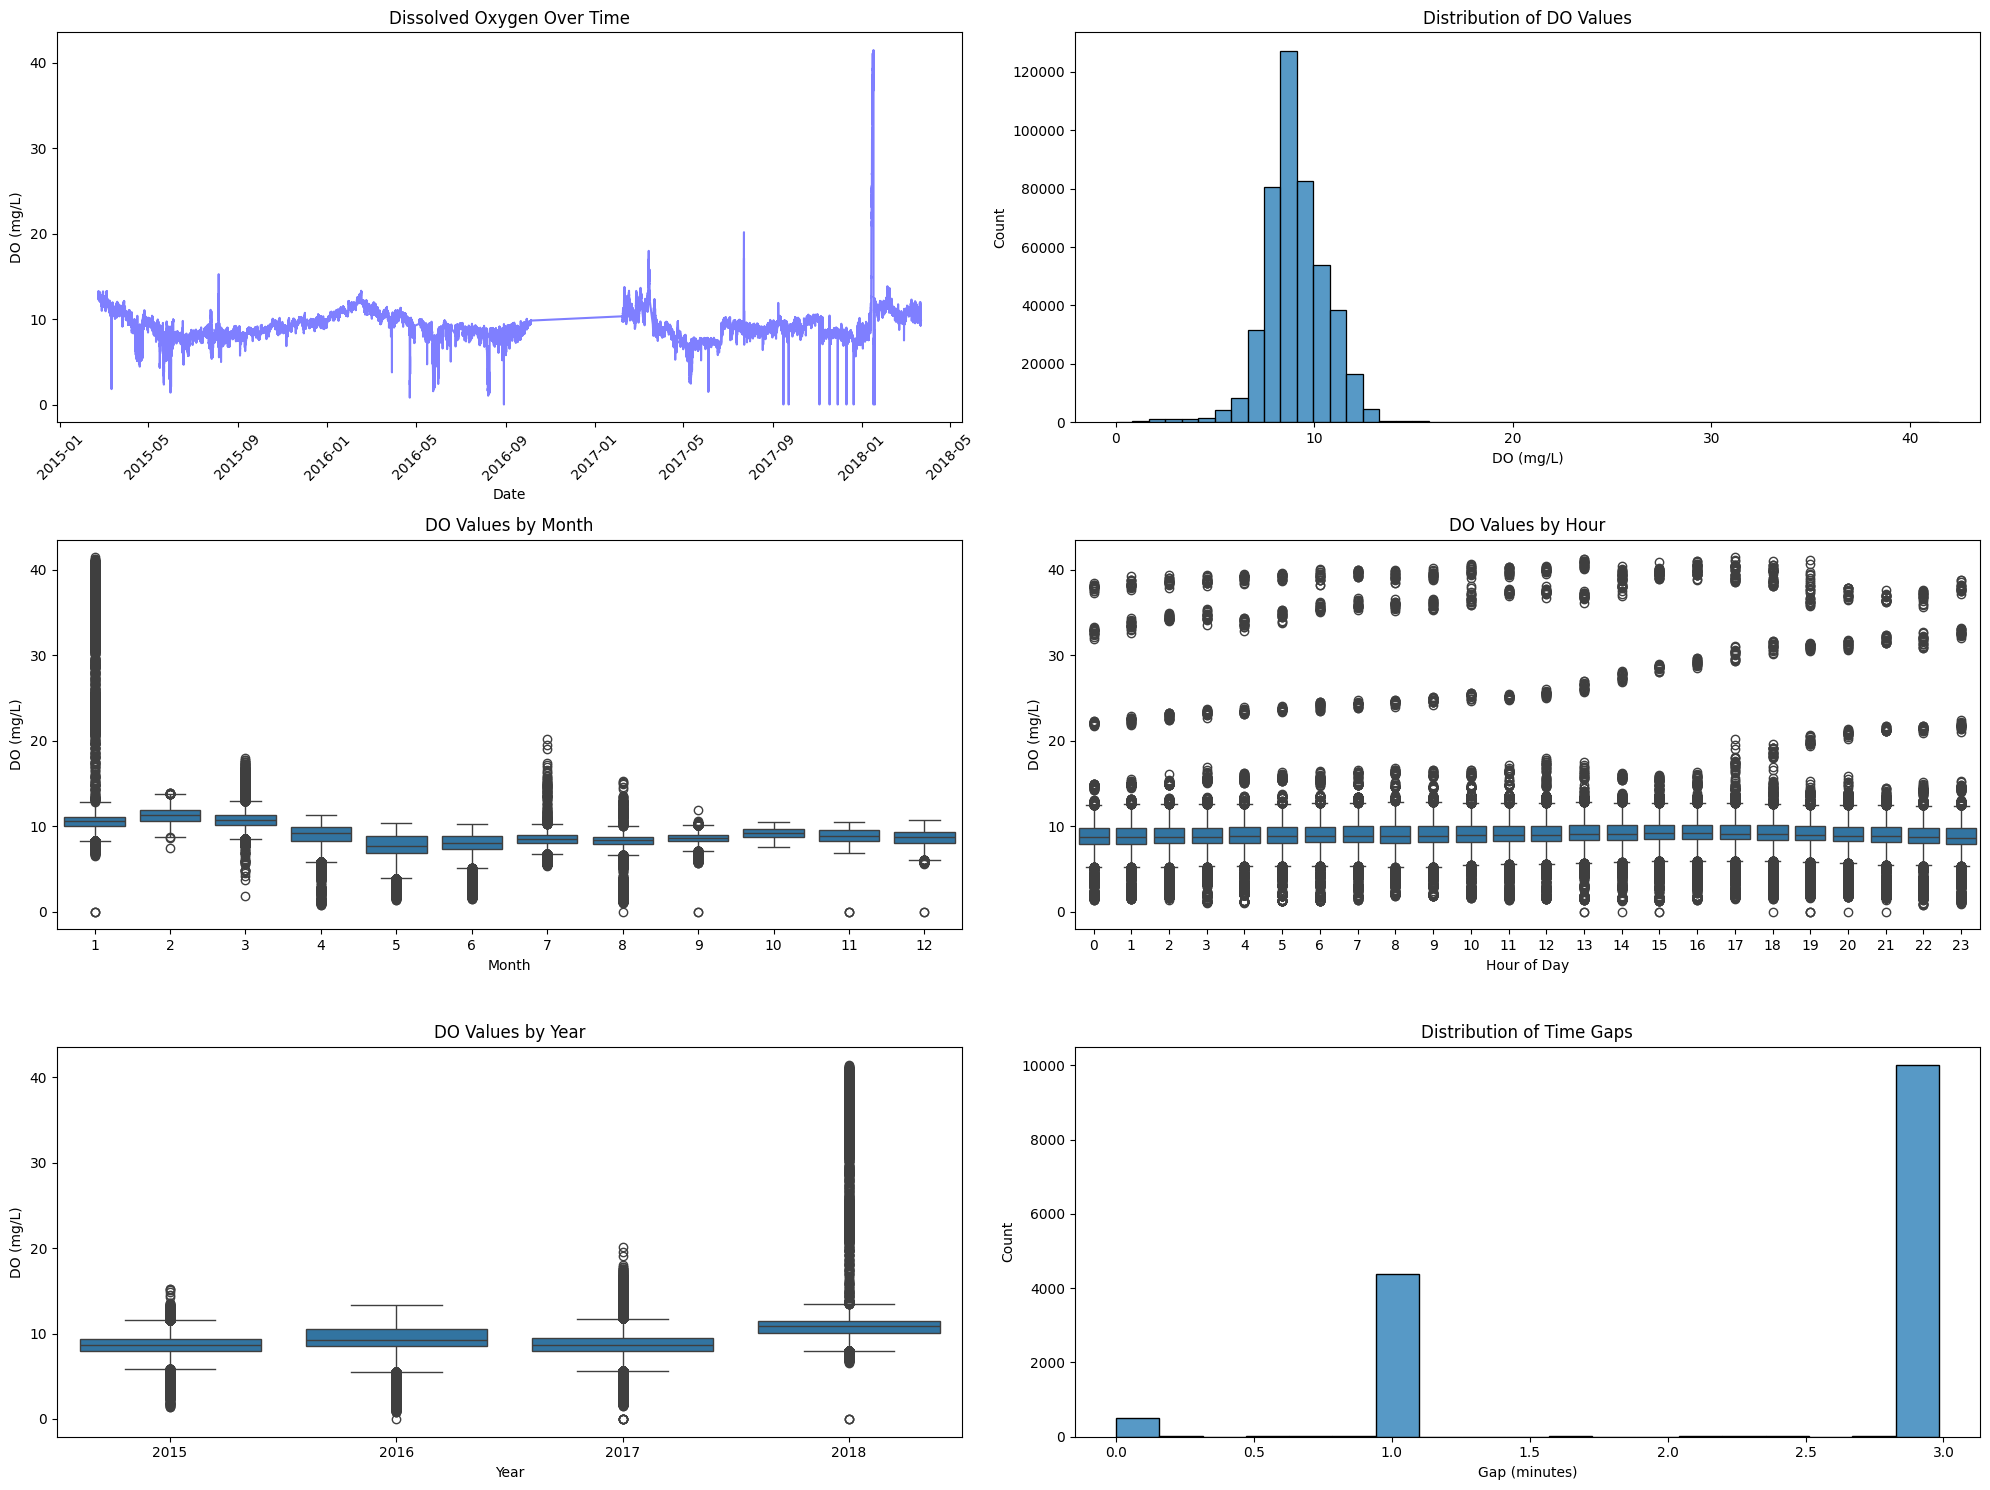


Data preprocessing completed successfully!


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [14]:
# Water Quality Analysis System: LEWAS Lab
# Anomaly Detection for Dissolved Oxygen Data

## 1. Setup and Configuration
# First, we'll import all necessary libraries and set up our environment:
# Importing necessary libraries

# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Statistical analysis
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Setup complete!")


## 2. Data Loading and Initial Processing
# load and process the water_DO.csv file:

def load_do_data(file_path='water_DO.csv'):
    """
    Load and process LEWAS Lab dissolved oxygen data with proper datetime parsing.
    """
    # Read CSV without parsing dates first
    df = pd.read_csv(file_path)
    
    # Convert to datetime with UTC=True to handle timezones properly
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
    
    # Sort by datetime
    df = df.sort_values('datetime')
    
    print("\nDataset Overview:")
    print(f"Time Range: {df['datetime'].min()} to {df['datetime'].max()}")
    print(f"Number of readings: {len(df)}")
    print(f"Sampling frequency: {df['datetime'].diff().mean()}")
    print("\nBasic statistics of DO values:")
    print(df['value'].describe())
    
    return df

# Load the data
do_data = load_do_data('water_DO.csv')


## 3. Data Quality Assessment
# Now check the quality of our data:


def assess_data_quality(df):
    """
    Perform comprehensive data quality assessment.
    """
    print("\nData Quality Assessment:")
    
    # Check for missing values
    missing = df.isnull().sum()
    print("\nMissing Values:")
    print(missing[missing > 0])
    
    # Check value ranges
    print("\nValue Ranges:")
    print(f"DO Range: {df['value'].min():.2f} to {df['value'].max():.2f} mg/L")
    
    # Calculate time gaps
    time_gaps = df['datetime'].diff()
    print("\nTime Gaps:")
    print(f"Minimum gap: {time_gaps.min()}")
    print(f"Maximum gap: {time_gaps.max()}")
    print(f"Mean gap: {time_gaps.mean()}")
    
    # Check for duplicates
    duplicates = df.duplicated('datetime').sum()
    print(f"\nDuplicate timestamps: {duplicates}")
    
    return {
        'missing_values': missing,
        'time_gaps': time_gaps,
        'duplicates': duplicates
    }

# Assess data quality
quality_metrics = assess_data_quality(do_data)


## 4. Data Visualization
# create comprehensive visualizations:

def create_visualizations(df):
    """
    Create comprehensive visualizations of the DO data.
    """
    # Create a copy of the dataframe
    df = df.copy()
    
    # Convert to naive datetime for plotting
    df['datetime'] = df['datetime'].dt.tz_localize(None)
    
    # Add time-based features
    df['hour'] = df['datetime'].dt.hour
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Time series plot
    plt.subplot(3, 2, 1)
    plt.plot(df['datetime'], df['value'], 'b-', alpha=0.5)
    plt.title('Dissolved Oxygen Over Time')
    plt.xlabel('Date')
    plt.ylabel('DO (mg/L)')
    plt.xticks(rotation=45)
    
    # 2. Distribution plot
    plt.subplot(3, 2, 2)
    sns.histplot(data=df, x='value', bins=50)
    plt.title('Distribution of DO Values')
    plt.xlabel('DO (mg/L)')
    
    # 3. Box plot by month
    plt.subplot(3, 2, 3)
    sns.boxplot(data=df, x='month', y='value')
    plt.title('DO Values by Month')
    plt.xlabel('Month')
    plt.ylabel('DO (mg/L)')
    
    # 4. Daily pattern
    plt.subplot(3, 2, 4)
    sns.boxplot(data=df, x='hour', y='value')
    plt.title('DO Values by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('DO (mg/L)')
    
    # 5. Values by year
    plt.subplot(3, 2, 5)
    sns.boxplot(data=df, x='year', y='value')
    plt.title('DO Values by Year')
    plt.xlabel('Year')
    plt.ylabel('DO (mg/L)')
    
    # 6. Time gaps analysis
    plt.subplot(3, 2, 6)
    time_gaps = df['datetime'].diff().dt.total_seconds() / 60  # Convert to minutes
    sns.histplot(time_gaps[time_gaps < time_gaps.quantile(0.95)])  # Exclude extreme gaps
    plt.title('Distribution of Time Gaps')
    plt.xlabel('Gap (minutes)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

# Create visualizations


## 5. Data Preprocessing
# Now prepare the data for anomaly detection:


def preprocess_data(df, resample_freq='1H'):
    """
    Preprocess the DO data for anomaly detection.
    """
    # Create copy of the data
    df_copy = df.copy()
    
    # Convert to naive datetime for processing
    df_copy['datetime'] = df_copy['datetime'].dt.tz_localize(None)
    
    # Set datetime as index
    df_copy.set_index('datetime', inplace=True)
    
    # Resample data to regular intervals
    df_resampled = df_copy['value'].resample(resample_freq).mean()
    
    # Handle missing values
    df_resampled = df_resampled.interpolate(method='linear')
    
    # Scale the data
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df_resampled.values.reshape(-1, 1))
    
    # Create processed DataFrame
    processed_df = pd.DataFrame(
        scaled_values, 
        index=df_resampled.index, 
        columns=['scaled_value']
    )
    processed_df['original_value'] = df_resampled.values
    
    return processed_df, scaler

# Preprocess the data

    # Create visualizations
create_visualizations(do_data)
    
    # Preprocess data for anomaly detection
processed_data, scaler = preprocess_data(do_data)
    
print("\nData preprocessing completed successfully!")



## 6. Anomaly Detection
# implement both statistical and LSTM-based anomaly detection:

def detect_anomalies(df, window_size=24, z_threshold=3):
    """
    Detect anomalies using statistical methods.
    """
    # Calculate rolling statistics
    rolling_mean = df['scaled_value'].rolling(window=window_size, center=True).mean()
    rolling_std = df['scaled_value'].rolling(window=window_size, center=True).std()
    
    # Calculate Z-scores
    z_scores = abs((df['scaled_value'] - rolling_mean) / rolling_std)
    
    # Detect anomalies
    df['is_anomaly'] = z_scores > z_threshold
    df['z_score'] = z_scores
    
    # Classify anomaly types
    df['anomaly_type'] = 'normal'
    df.loc[z_scores > z_threshold * 2, 'anomaly_type'] = 'sensor_fault'
    df.loc[(z_scores > z_threshold) & (z_scores <= z_threshold * 2), 
           'anomaly_type'] = 'environmental'
    
    return df

# Detect anomalies
data_with_anomalies = detect_anomalies(processed_data)

## 7. Visualize Results
# create interactive visualizations of the anomalies:

def plot_anomalies(df):
    """
    Create interactive visualization of anomaly detection results.
    """
    fig = go.Figure()
    
    # Plot original data
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['original_value'],
        mode='lines',
        name='Original Data',
        line=dict(color='blue', width=1)
    ))
    
    # Plot sensor faults
    sensor_faults = df[df['anomaly_type'] == 'sensor_fault']
    fig.add_trace(go.Scatter(
        x=sensor_faults.index,
        y=sensor_faults['original_value'],
        mode='markers',
        name='Sensor Faults',
        marker=dict(color='red', size=8, symbol='x')
    ))
    
    # Plot environmental anomalies
    env_anomalies = df[df['anomaly_type'] == 'environmental']
    fig.add_trace(go.Scatter(
        x=env_anomalies.index,
        y=env_anomalies['original_value'],
        mode='markers',
        name='Environmental Anomalies',
        marker=dict(color='green', size=10, symbol='circle')
    ))
    
    # Update layout
    fig.update_layout(
        title="Dissolved Oxygen Anomaly Detection Results",
        xaxis_title="DateTime",
        yaxis_title="Dissolved Oxygen (mg/L)",
        showlegend=True,
        template="plotly_white",
        height=600
    )
    
    fig.show()

# Plot results
plot_anomalies(data_with_anomalies)


## 8. Analysis Summary
# create a summary of our findings:


def create_summary(df):
    """
    Create a summary of the anomaly detection results.
    """
    print("\nAnomaly Detection Summary:")
    print(f"Total observations: {len(df)}")
    print(f"Total anomalies detected: {df['is_anomaly'].sum()}")
    print(f"Sensor faults: {(df['anomaly_type'] == 'sensor_fault').sum()}")
    print(f"Environmental anomalies: {(df['anomaly_type'] == 'environmental').sum()}")
    
    print("\nTemporal Distribution of Anomalies:")
    df['month'] = df.index.month
    monthly_anomalies = df[df['is_anomaly']].groupby('month').size()
    print(monthly_anomalies)

# Create summary
create_summary(data_with_anomalies)